Let's run a Monte Carlo with a new transient metric that computes some agregate of transient properties

# Modeling the Detectability of a Population of Transients

A common LSST science case is to detect a large sample of some family of transient objects for further study.  A good proxy for a scientific Figure of Merit in this case is the sample size or fraction of objects detected.  In this tutorial, we will define a simple example model lightcurve, and then use MAF to quantify the detectability of a sample of such objects.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles

# The Metric

This metric has a method that defines the light curve shape. When run with something like the HealpixSlicer, MAF will loop over a grid of points in the sky. At each location it will then run this metric to determine what fraction of transient objects would be detected. Note that we are running nested for-loops, so this could become computationally expensive if we have a larege number of objects and/or run at high spatial resolution.



In [2]:
class TransientMonteMetric(metrics.BaseMetric):
    """
    Generate a population of transient objects and see what fraction are detected
    """
    
    def __init__(self, metricName='TransientMonteMetric', mjdCol='expMJD', m5Col='fiveSigmaDepth',
                 filterCol='filter', duration=1., survey_start=49353,
                 survey_length=3652, **kwargs):
        self.mjdCol = mjdCol
        self.m5Col = m5Col
        self.filterCol = filterCol
        super(TransientMonteMetric, self).__init__(col=[self.mjdCol, self.m5Col, self.filterCol],
                                                  units='Fraction Detected',
                                                  metricName=metricName, **kwargs)
        # Properties of the transient object
        self.duration = duration
        self.survey_start = survey_start
        self.survey_length = survey_length
        
    def lightCurve(self, t, t0, m_r_0):
        """A simple top-hat light curve.
        
        Parameters
        ----------
        t : array
            Times to generate lightcurve points (mjd)
        t0 : float
            Initial time (mjd)
        m_r_0 : float
            initial r-band brightness (mags)
        """
        
        good = np.where( (t >= t0) & (t <= t0+self.duration))
        mags = np.zeros(t.size, dtype=float)
        mags.fill(300.) #  Set to very faint by default
        mags[good] = m_r_0
        return mags
        
    def run(self,  dataSlice, slicePoint=None):
        # Note, we can access information about where in the sky we are
        # using the information in slicePoints (e.g., if we wanted to vary the 
        # rate of objects with galactic coordinates).
        
        objRate = 0.7 # how many go off per day
        # decide how many objects we want to generate
        nObj = np.random.poisson(self.survey_length*objRate)
        t0s = np.random.rand(nObj)*self.survey_length
        m0s = np.random.rand(nObj)*2.+20.
        t = dataSlice[self.mjdCol] - dataSlice[self.mjdCol].min()
        detected = np.zeros(t0s.size)
        # Loop though each generated transient and decide if it was detected
        # This could be a more complicated piece of code, for example demanding 
        # A color measurement in a night.
        for i,t0 in enumerate(t0s):
            lc = self.lightCurve(t, t0, m0s[i])
            detectTest = dataSlice[self.m5Col] - lc
            if detectTest.max() > 0:
               detected[i] += 1
        # Return the fraction of transients detected
        return float(np.sum(detected))/float(nObj)
    

(30, 10)

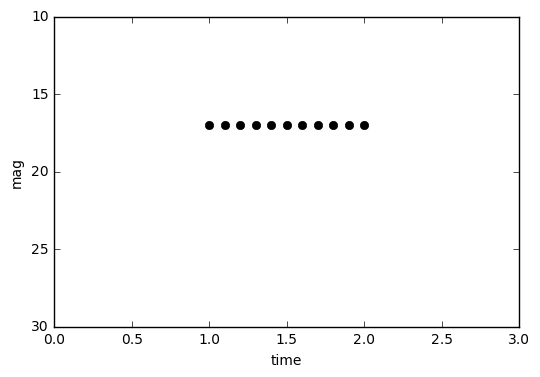

In [3]:
# A quick test of out light curve shape
metric = TransientMonteMetric()
t = np.arange(0,3,.1)
t0 = 1.
m_r_0 = 17
lc = metric.lightCurve(t, t0, m_r_0)
plt.plot(t, lc, 'ko')
plt.xlabel('time')
plt.ylabel('mag')
plt.ylim([30, 10])

In [4]:
runName = 'enigma_1189'
opsdb = db.OpsimDatabase(runName + '_sqlite.db')
outDir = 'TransientsMonte'
resultsDb = db.ResultsDb(outDir=outDir)

In [5]:
metric = TransientMonteMetric(survey_length=365.)
sql = 'night < 365'
slicer = slicers.HealpixSlicer(nside=8)
bundle = metricBundles.MetricBundle(metric, slicer, sql, runName=runName)
bundleList = [bundle]
bundleDict = metricBundles.makeBundlesDictFromList(bundleList)

Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes


Querying database with constraint night < 365
Found 271946 visits
Running:  ['enigma_1189_TransientMonteMetric_night_lt_365_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night < 365" constraint now.
monopole: 0.0744049  dipole: lon: 44.468, lat: -77.9012, amp: 0.0456931
Plotting complete.


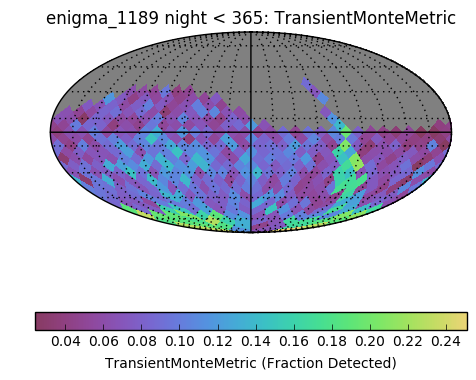

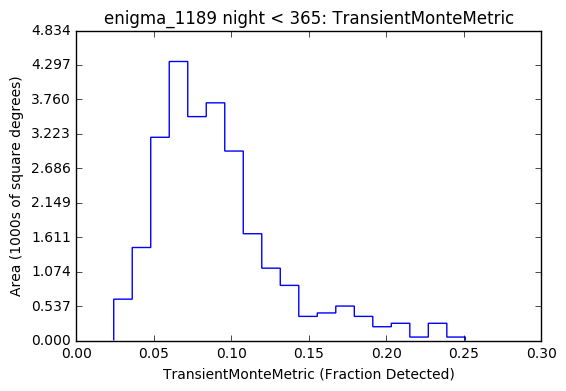

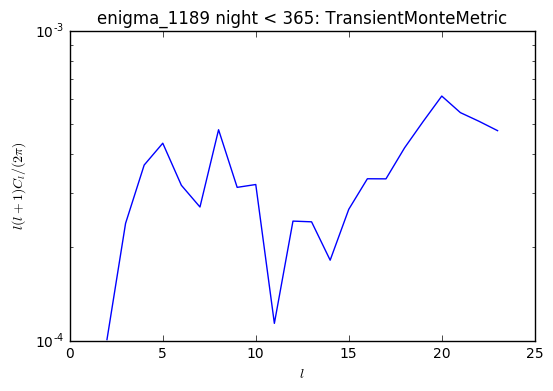

In [6]:
bgroup = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)

Querying database with constraint night < 365
Found 271946 visits
Running:  ['enigma_1189_TransientMonteMetric_night_lt_365_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night < 365" constraint now.
monopole: 0.350507  dipole: lon: 113.341, lat: -57.9994, amp: 0.121257
Plotting complete.


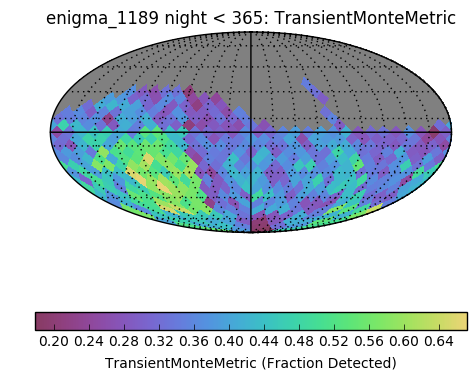

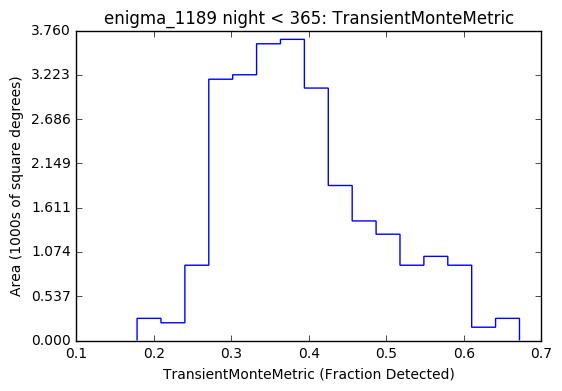

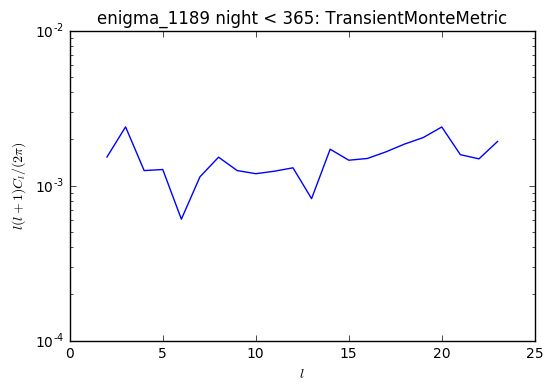

In [8]:
# Let's try it again, only now with transients that last longer
metric = TransientMonteMetric(duration=10., survey_length=365.)
bundle = metricBundles.MetricBundle(metric, slicer, sql, runName=runName)
bundleList = [bundle]
bundleDict = metricBundles.makeBundlesDictFromList(bundleList)

bgroup = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)

So, as expected, if a transient lasts for 1-day, LSST detects ~7%, but if it lasts 10 days we detect ~40% of them.